Random seeds set to 42 for reproducibility
SwiftFormer 30-day SEQUENCE - RESEARCH PIPELINE (90% Train / 10% Test)
Configuration:
  d_model: 128
  n_heads: 8
  n_layers: 4
  d_ff: 512
  dropout: 0.1
  sequence_length: 30
  batch_size: 64
  learning_rate: 0.001
  num_epochs: 100
  patience: 10
  train_ratio: 0.9
  val_ratio_from_train: 0.1

Using device: cpu

STEP 1: DATA LOADING AND PREPARATION
--------------------------------------------------
Loading NVDA data from CSV file...
Successfully loaded 5030 data points for NVDA
Date range: 2005-07-01 to 2025-07-01
Price range: $0.14 - $157.99
Loaded 5030 data points for NVDA
Preparing data with 5030 total samples
Split ratios: Train=90%, Test=10%
Data splits:
  Training: 4527 samples (indices 0 to 4526) - 90.0%
  Test: 503 samples (indices 4527 to 5029) - 10.0%
  Note: Validation data (10% of training) will be created from training data
Data normalized to range [-1, 1]
Training data range: [-1.000, 1.000]
Scaler saved to research_data/NVDA/

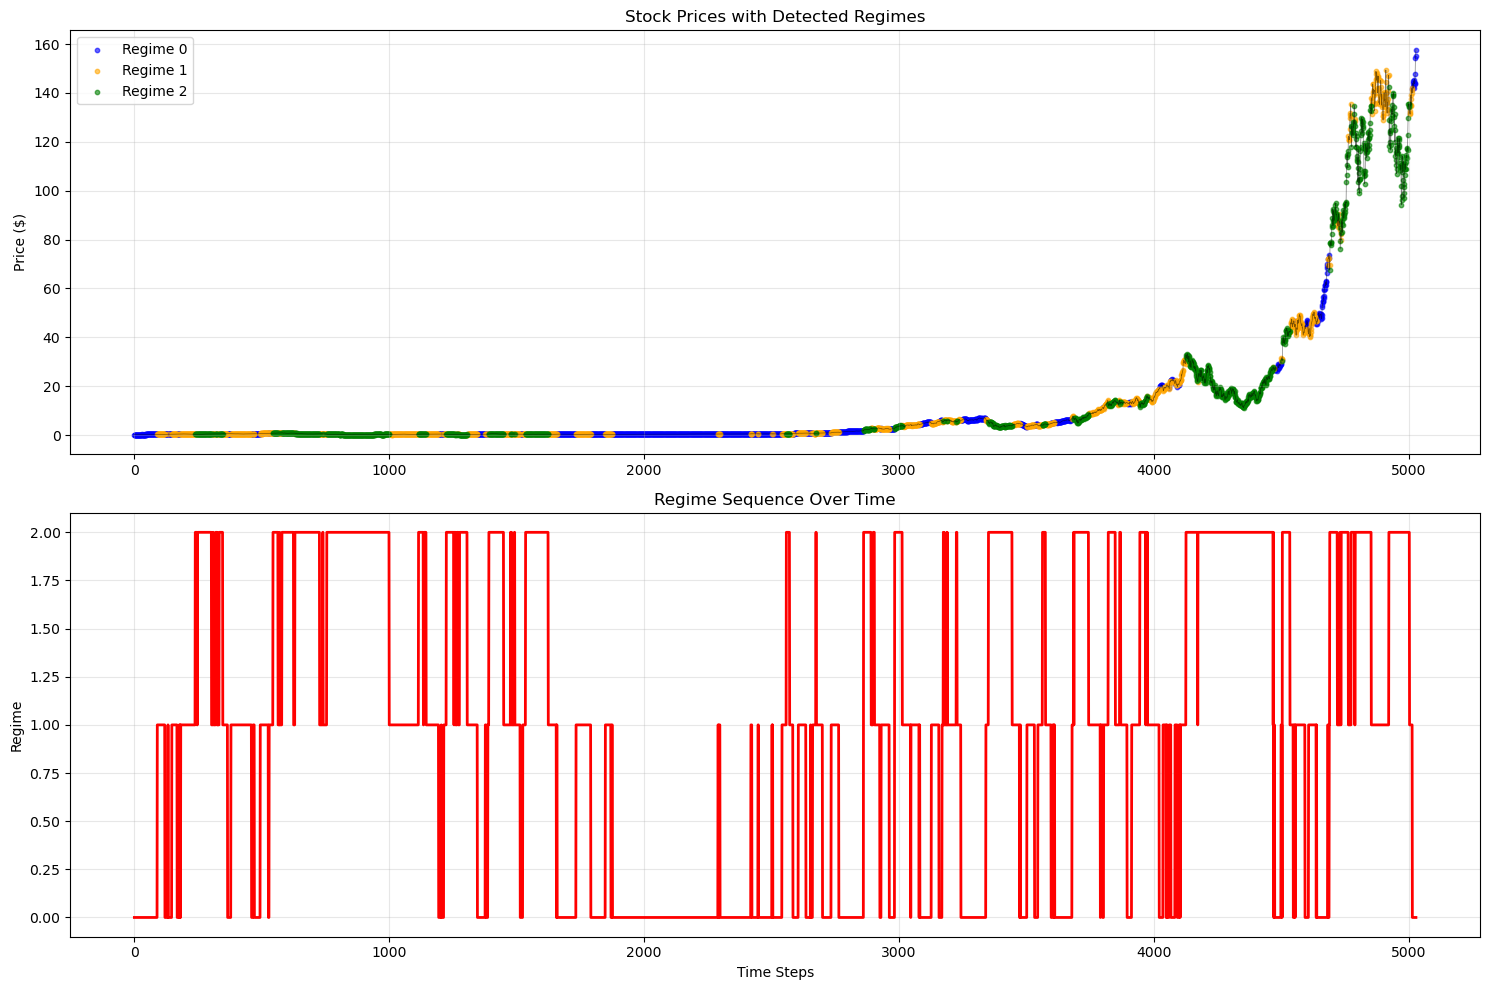

Regime detection plot saved with 5029 data points
✅ Regime detection plot saved successfully
✅ Regime analysis completed and saved to research_data/NVDA/regime_analysis.json

🔍 ANALYSIS OF YOUR RESULTS:
   • Training stability: 0.956 (Very stable - few regime changes)
   • Test stability: 0.964 (Also stable)
   • Both periods show high stability, which is good for models
   • Training period was more volatile - model learned volatility patterns
   • Test period is more stable - different from training conditions

STEP 2: CREATING DATA LOADERS WITH VALIDATION SPLIT
--------------------------------------------------
Data loaders created:
  Train batches: 64 (from 4048 samples)
  Validation batches: 8 (from 449 samples - 10% of training)
  Test batches: 8 (from 473 samples)

STEP 3: MODEL INITIALIZATION
--------------------------------------------------
SwiftFormer Model initialized:
  Total parameters: 793,473
  Trainable parameters: 793,473
  Model size: ~3.03 MB

STEP 4: MODEL TRAINING

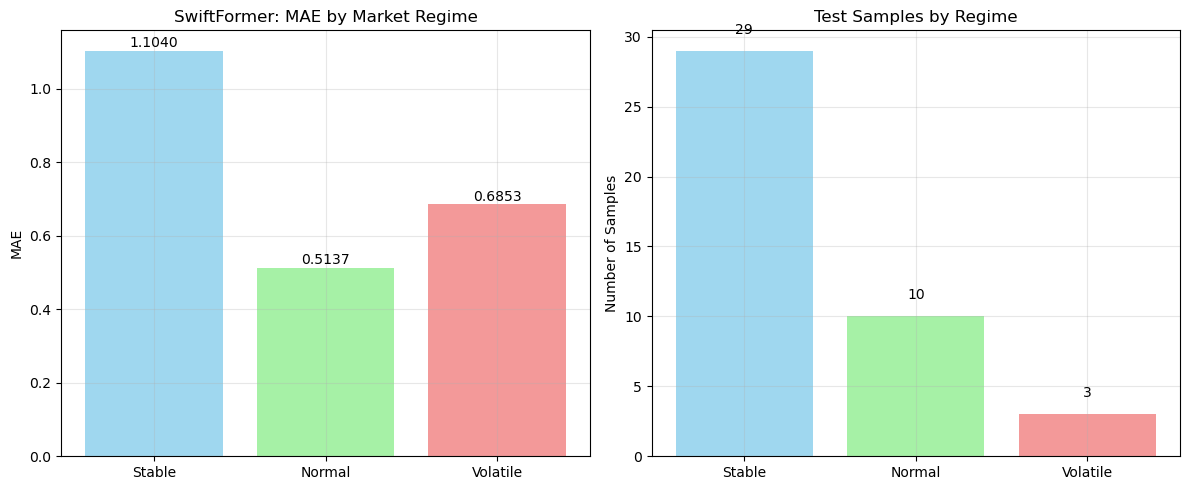

✅ Regime performance plot saved to plots/NVDA/

🔍 COMPARISON OF MULTI-STEP EVALUATION METHODS:
Performing multi-step evaluation (1 to 10 steps) with seq_len=30
OLD Multi-step evaluation (limited samples):
  1-step: MAE=0.173436, RMSE=0.181959
  2-step: MAE=0.277161, RMSE=0.289376
  3-step: MAE=0.329490, RMSE=0.344016
  4-step: MAE=0.355484, RMSE=0.371293
  5-step: MAE=0.368810, RMSE=0.385729
  6-step: MAE=0.377004, RMSE=0.394937
  7-step: MAE=0.382658, RMSE=0.401785
  8-step: MAE=0.387245, RMSE=0.407620
  9-step: MAE=0.393082, RMSE=0.414664
  10-step: MAE=0.397237, RMSE=0.420610

NEW Multi-step evaluation (all test data):
Performing multi-step evaluation on 463 samples (using all test data)
FIXED Multi-step evaluation completed:
  1-step: MAE=0.996057, RMSE=1.148730, Samples=463
  2-step: MAE=1.151010, RMSE=1.304912, Samples=463
  3-step: MAE=1.199346, RMSE=1.348859, Samples=463
  4-step: MAE=1.221375, RMSE=1.367772, Samples=463
  5-step: MAE=1.236161, RMSE=1.380571, Samples=463
  6-st

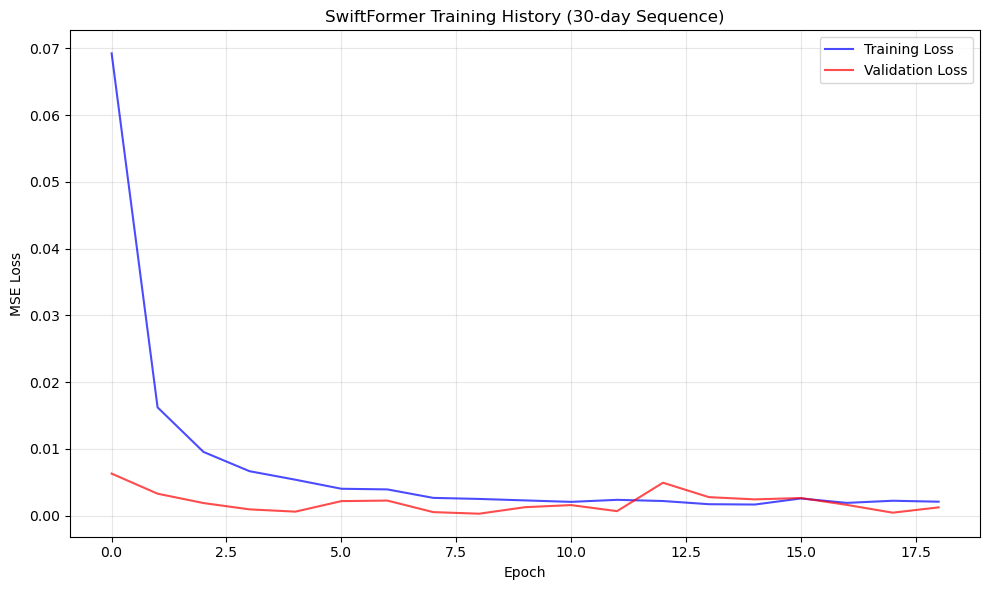

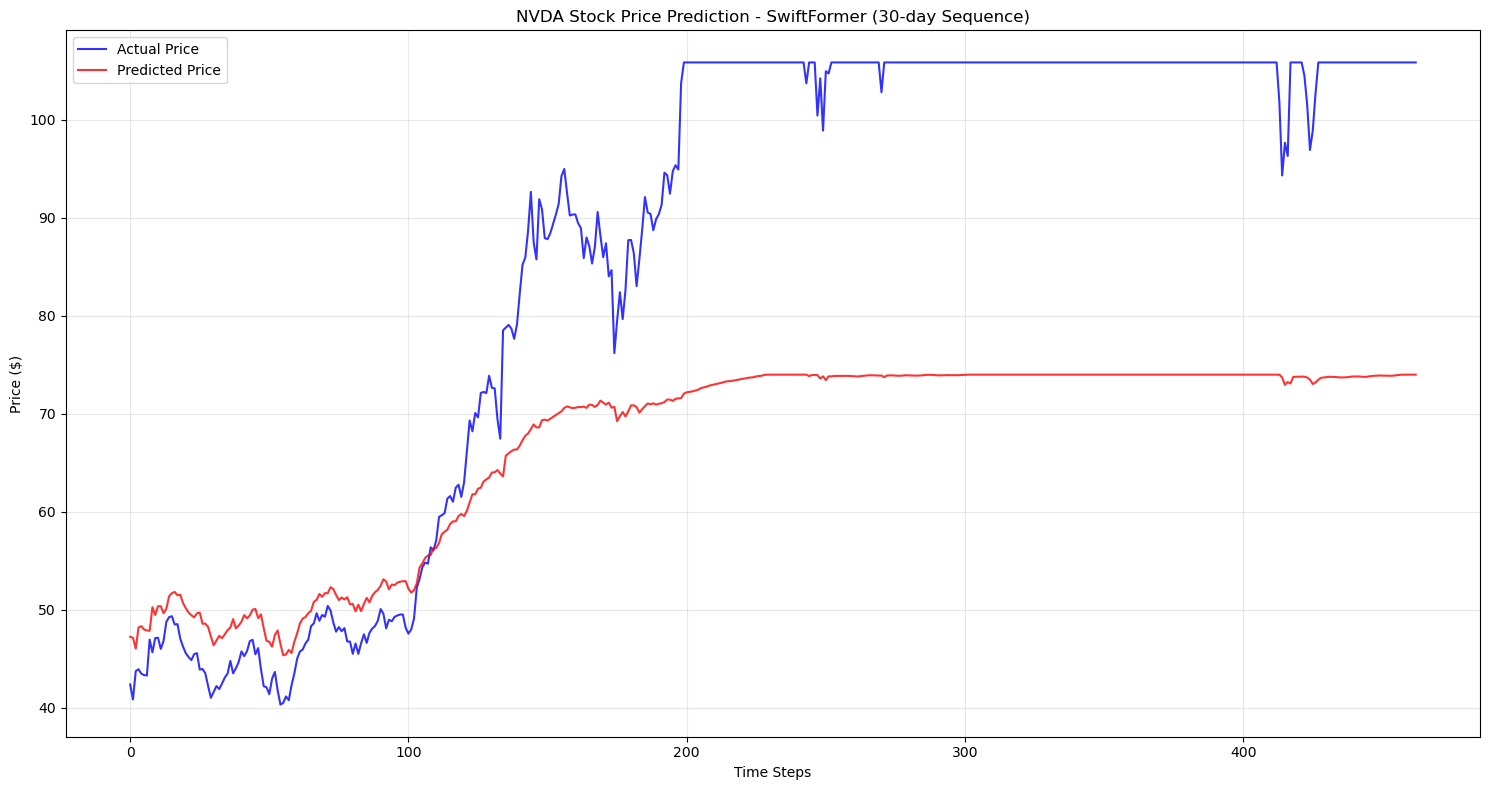

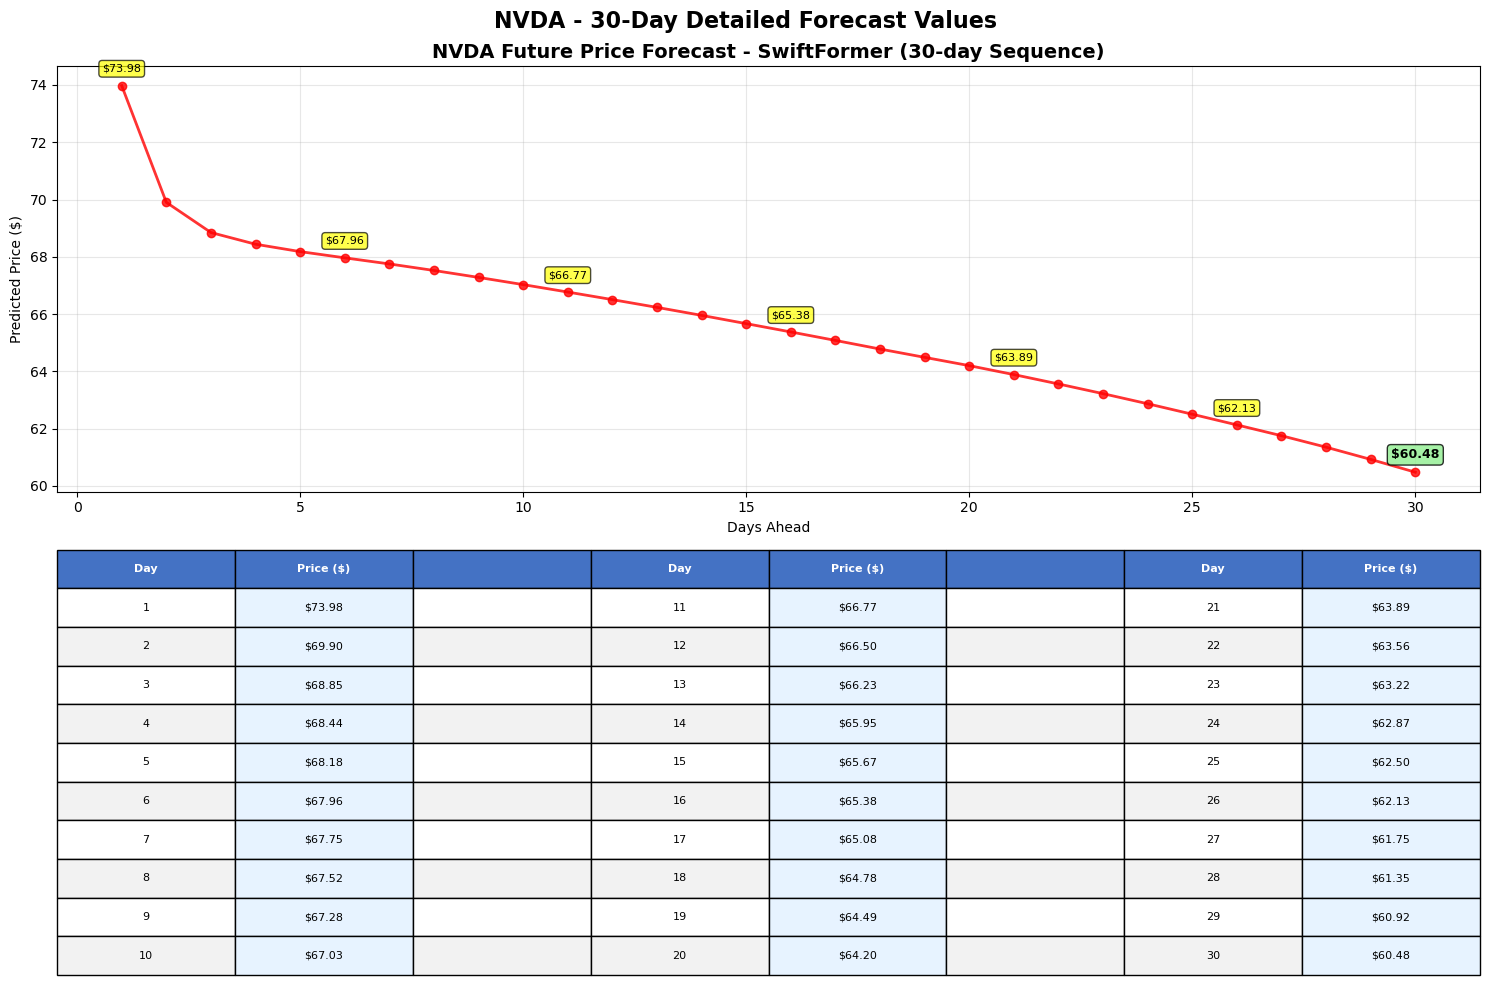


STEP 8: SAVING RESEARCH RESULTS
--------------------------------------------------
Research results saved to research_data/NVDA/SwiftFormer_30day_results.json

STEP 9: RESEARCH SUMMARY AND BASELINE INSTRUCTIONS

🎯 SwiftFormer 30-day SEQUENCE RESULTS SUMMARY:
   Stock: NVDA
   Model: SwiftFormer (30-day sequence, 793,473 parameters)
   Training time: 117.1 seconds
   Data split: 90% train / 10% test (validation: 10% of training)
   Best performance:
     • 1-step MAE: 0.996057
     • 1-step RMSE: 1.148730
     • 10-step MAE: 1.297250
     • 10-step RMSE: 1.436779

📁 FILES SAVED FOR BASELINE COMPARISON:
   Data directory: research_data/NVDA/
   • scaler.pkl - Use this EXACT scaler for all baseline models
   • train_data_raw.npy, test_data_raw.npy
   • train_data_scaled.npy, test_data_scaled.npy
   • X_train_seq1.npy, y_train_seq1.npy - For 30-day sequence baselines
   • X_train_seq30.npy, y_train_seq30.npy - For 30-day sequence baselines
   • data_info.json - Complete data split informa

In [ ]:
from regime_aware_system import (
    VolatilityRegimeDetector,
    HMMRegimeDetector,
    plot_regime_detection
)

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import math
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import OneCycleLR
import warnings
import pickle
import os
import random
from datetime import datetime
import json
warnings.filterwarnings('ignore')

# =============================================================================
# REPRODUCIBILITY SETUP
# =============================================================================
def set_random_seeds(seed=42):
    """Set random seeds for reproducibility"""
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Random seeds set to {seed} for reproducibility")

# Set seeds immediately
set_random_seeds(42)

# =============================================================================
# MODEL ARCHITECTURE
# =============================================================================
class PositionalEncoding(nn.Module):
    """Positional Encoding"""
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        # Calculate div_term
        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                           (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)

        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

class TransformerEncoderLayer(nn.Module):
    """Single Transformer Encoder Layer"""
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super(TransformerEncoderLayer, self).__init__()

        self.self_attn = nn.MultiheadAttention(d_model, n_heads, dropout=dropout)
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.ReLU()

    def forward(self, src):
        # Multi-head self-attention
        src2, _ = self.self_attn(src, src, src)
        src = self.norm1(src + self.dropout(src2))

        # Feed-forward network
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = self.norm2(src + self.dropout(src2))

        return src

class SwiftFormer(nn.Module):
    """SwiftFormer: Lightweight Transformer for Stock Price Prediction"""
    def __init__(self, d_model=128, n_heads=8, n_layers=4, d_ff=512,
                 dropout=0.1, max_len=5000, input_dim=1):
        super(SwiftFormer, self).__init__()

        # Input linear transformation
        self.input_linear = nn.Linear(input_dim, d_model)

        # Positional encoding
        self.pos_encoding = PositionalEncoding(d_model, max_len)

        # Transformer encoder layers
        self.encoder_layers = nn.ModuleList([
            TransformerEncoderLayer(d_model, n_heads, d_ff, dropout)
            for _ in range(n_layers)
        ])

        # Output layer for forecasting
        self.output_linear = nn.Linear(d_model, 1)
        self.dropout = nn.Dropout(dropout)

        self.d_model = d_model

    def forward(self, src):
        # src expected shape: (batch_size, seq_len, input_dim)
        batch_size, seq_len, input_dim = src.shape

        # Transform to (seq_len, batch_size, input_dim) for transformer
        src = src.transpose(0, 1)

        # Linear transformation and scaling
        src = self.input_linear(src) * math.sqrt(self.d_model)

        # Add positional encoding
        src = self.pos_encoding(src)
        src = self.dropout(src)

        # Pass through encoder layers
        for layer in self.encoder_layers:
            src = layer(src)

        # Take the last time step for prediction
        output = self.output_linear(src[-1])  # (batch_size, 1)

        return output

# =============================================================================
# DATASET CLASS
# =============================================================================
class StockDataset(Dataset):
    """Dataset class for stock data with configurable sequence length"""
    def __init__(self, data, sequence_length=1):
        self.data = data
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.sequence_length]
        y = self.data[idx + self.sequence_length]
        return torch.FloatTensor(x).unsqueeze(-1), torch.FloatTensor([y])

# =============================================================================
# DATA LOADING AND PREPROCESSING
# =============================================================================
def fetch_stock_data(ticker, start_date, end_date, data_source='csv'):
    """
    Fetch stock data from specified source

    Args:
        ticker: Stock ticker symbol
        start_date: Start date for data
        end_date: End date for data
        data_source: 'yfinance' or 'csv'
    """
    try:
        if data_source == 'yfinance':
            print(f"Fetching {ticker} data from Yahoo Finance...")
            stock = yf.download(ticker, start=start_date, end=end_date)
            close_prices = stock['Close'].values.astype(np.float32)

        elif data_source == 'csv':
            print(f"Loading {ticker} data from CSV file...")
            # Assuming CSV file named {ticker}_data.csv
            stock = pd.read_csv(f"{ticker}_data.csv")
            stock['Close'] = pd.to_numeric(stock['Close'], errors='coerce')
            stock = stock.dropna(subset=['Close'])
            close_prices = stock['Close'].values.astype(np.float32)

        if len(close_prices) == 0:
            print(f"No valid price data found for {ticker}")
            return None

        print(f"Successfully loaded {len(close_prices)} data points for {ticker}")
        print(f"Date range: {start_date} to {end_date}")
        print(f"Price range: ${close_prices.min():.2f} - ${close_prices.max():.2f}")

        return close_prices

    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        return None

def prepare_data(data, train_ratio=0.90, sequence_length=1, save_path="research_data/"):
    """
    Prepare data with 90% training / 10% testing split
    Validation data will be taken from training data later

    Args:
        data: Raw stock price data
        train_ratio: Training data ratio (0.90)
        sequence_length: Sequence length for model input
        save_path: Path to save processed data

    Returns:
        train_dataset, test_dataset, scaler, data_info
    """

    # Validate input data
    if data is None or len(data) == 0:
        raise ValueError("Input data is empty or None")

    if len(data) < sequence_length + 10:
        raise ValueError(f"Data length ({len(data)}) too small for sequence length {sequence_length}")

    print(f"Preparing data with {len(data)} total samples")
    print(f"Split ratios: Train={train_ratio:.0%}, Test={1-train_ratio:.0%}")

    # Create directory if it doesn't exist
    os.makedirs(save_path, exist_ok=True)

    # Remove outliers
    mean_val = np.mean(data)
    std_val = np.std(data)
    data = np.clip(data, mean_val - 3*std_val, mean_val + 3*std_val)

    # Calculate split indices
    train_size = int(len(data) * train_ratio)
    test_size = len(data) - train_size

    # Split data temporally (chronological order)
    train_data = data[:train_size]
    test_data = data[train_size:]

    print(f"Data splits:")
    print(f"  Training: {len(train_data)} samples (indices 0 to {train_size-1}) - {len(train_data)/len(data)*100:.1f}%")
    print(f"  Test: {len(test_data)} samples (indices {train_size} to {len(data)-1}) - {len(test_data)/len(data)*100:.1f}%")
    print(f"  Note: Validation data (10% of training) will be created from training data")

    # Validate split data
    if len(train_data) < sequence_length + 10:
        raise ValueError(f"Training data too small: {len(train_data)} samples")
    if len(test_data) < sequence_length + 5:
        raise ValueError(f"Test data too small: {len(test_data)} samples")

    # Normalize data using MinMaxScaler to range [-1, 1]
    # CRITICAL: Fit scaler only on training data to prevent data leakage
    scaler = MinMaxScaler(feature_range=(-1, 1))
    train_data_scaled = scaler.fit_transform(train_data.reshape(-1, 1)).flatten()
    test_data_scaled = scaler.transform(test_data.reshape(-1, 1)).flatten()

    print(f"Data normalized to range [-1, 1]")
    print(f"Training data range: [{train_data_scaled.min():.3f}, {train_data_scaled.max():.3f}]")

    # Save scaler for baseline model comparison
    with open(os.path.join(save_path, 'scaler.pkl'), 'wb') as f:
        pickle.dump(scaler, f)
    print(f"Scaler saved to {os.path.join(save_path, 'scaler.pkl')}")

    # Save raw data splits for baseline models
    np.save(os.path.join(save_path, 'train_data_raw.npy'), train_data)
    np.save(os.path.join(save_path, 'test_data_raw.npy'), test_data)

    # Save scaled data splits
    np.save(os.path.join(save_path, 'train_data_scaled.npy'), train_data_scaled)
    np.save(os.path.join(save_path, 'test_data_scaled.npy'), test_data_scaled)

    # Create sequences for baseline models (they will use different sequence lengths)
    def create_sequences_for_baseline(data, seq_len):
        X, y = [], []
        for i in range(len(data) - seq_len):
            X.append(data[i:(i + seq_len)])
            y.append(data[i + seq_len])
        return np.array(X), np.array(y)

    # Save sequences for different sequence lengths (for baseline comparison)
    for seq_len in [1, 30]:
        if len(train_data_scaled) > seq_len:
            X_train, y_train = create_sequences_for_baseline(train_data_scaled, seq_len)
            X_test, y_test = create_sequences_for_baseline(test_data_scaled, seq_len)

            np.save(os.path.join(save_path, f'X_train_seq{seq_len}.npy'), X_train)
            np.save(os.path.join(save_path, f'y_train_seq{seq_len}.npy'), y_train)
            np.save(os.path.join(save_path, f'X_test_seq{seq_len}.npy'), X_test)
            np.save(os.path.join(save_path, f'y_test_seq{seq_len}.npy'), y_test)

            print(f"Sequences saved for seq_length={seq_len}: {X_train.shape}, {X_test.shape}")

    # Save comprehensive metadata for research
    data_info = {
        'total_samples': len(data),
        'train_samples': len(train_data),
        'test_samples': len(test_data),
        'train_ratio': train_ratio,
        'test_ratio': 1 - train_ratio,
        'sequence_length': sequence_length,
        'scaler_range': (-1, 1),
        'data_min': float(data.min()),
        'data_max': float(data.max()),
        'train_indices': (0, train_size),
        'test_indices': (train_size, len(data)),
        'validation_note': 'Validation data (10% of training) created from training data using random_split',
        'created_timestamp': datetime.now().isoformat(),
        'random_seed': 42
    }

    with open(os.path.join(save_path, 'data_info.json'), 'w') as f:
        json.dump(data_info, f, indent=2)

    print(f"Data info saved to {os.path.join(save_path, 'data_info.json')}")

    # Create PyTorch datasets for SwiftFormer
    train_dataset = StockDataset(train_data_scaled, sequence_length)
    test_dataset = StockDataset(test_data_scaled, sequence_length)

    print(f"PyTorch datasets created:")
    print(f"  Train dataset: {len(train_dataset)} samples")
    print(f"  Test dataset: {len(test_dataset)} samples")
    print(f"All data saved to {save_path} for baseline model comparison")

    return train_dataset, test_dataset, scaler, data_info

# =============================================================================
# TRAINING FUNCTIONS
# =============================================================================
def train_model(model, train_loader, val_loader, num_epochs=100,
                learning_rate=0.001, device='cpu', patience=10):
    """Train the SwiftFormer model with comprehensive logging"""
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)

    # OneCycleLR scheduler
    scheduler = OneCycleLR(optimizer, max_lr=learning_rate,
                          steps_per_epoch=len(train_loader), epochs=num_epochs)

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    best_epoch = 0

    print(f"Starting training on {device}")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_batches = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()

            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            scheduler.step()

            train_loss += loss.item()
            train_batches += 1

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_batches = 0

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += criterion(output, target).item()
                val_batches += 1

        # Calculate average losses
        avg_train_loss = train_loss / train_batches
        avg_val_loss = val_loss / val_batches

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_epoch = epoch
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_SwiftFormer_30day.pth')
        else:
            patience_counter += 1

        # Print progress
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f'Epoch [{epoch+1:3d}/{num_epochs}] | '
                  f'Train Loss: {avg_train_loss:.6f} | '
                  f'Val Loss: {avg_val_loss:.6f} | '
                  f'Best: {best_val_loss:.6f} (Epoch {best_epoch+1})')

        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1} (patience={patience})")
            break

    # Load best model
    model.load_state_dict(torch.load('best_SwiftFormer_30day.pth'))
    print(f"Training completed. Best validation loss: {best_val_loss:.6f} at epoch {best_epoch+1}")

    return model, train_losses, val_losses, best_val_loss

# =============================================================================
# EVALUATION FUNCTIONS
# =============================================================================
def multi_step_evaluation(model, test_data_scaled, scaler, max_steps=10, device='cpu', sequence_length=30):

    """
    Evaluate model performance for multi-step forecasting (1 to max_steps)
    This is the ACADEMIC EVALUATION approach for research comparison
    """
    model.eval()
    results = {}

    # Use first part of test data for evaluation
    eval_length = min(100, len(test_data_scaled) - max_steps - sequence_length)

    if eval_length < max_steps:
        print(f"Warning: Test data too short for {max_steps}-step evaluation")
        return results

    print(f"Performing multi-step evaluation (1 to {max_steps} steps) with seq_len={sequence_length}")

    for steps in range(1, max_steps + 1):
        all_predictions = []
        all_actuals = []

        with torch.no_grad():
            for i in range(eval_length):
                if i + sequence_length + steps >= len(test_data_scaled):
                    break

                # CHANGE: Get sequence of length 'sequence_length'
                current_sequence = test_data_scaled[i:i + sequence_length].copy()
                actual_future = test_data_scaled[i + sequence_length:i + sequence_length + steps + 1]

                # Perform multi-step prediction (autoregressive)
                predictions = []
                working_sequence = current_sequence.copy()

                for step in range(steps):
                    # CHANGE: Prepare input with full sequence
                    # Shape: (batch_size=1, seq_len=sequence_length, input_dim=1)
                    model_input = torch.tensor(working_sequence, dtype=torch.float32)
                    model_input = model_input.unsqueeze(0).unsqueeze(-1)  # Add batch and feature dims
                    model_input = model_input.to(device)

                    pred = model(model_input)
                    pred_value = pred.cpu().item()
                    predictions.append(pred_value)

                    # CHANGE: Update sequence for next step (slide window)
                    working_sequence = np.concatenate([working_sequence[1:], [pred_value]])

                # Store results
                if steps == 1:
                    all_predictions.extend([predictions[0]])
                    all_actuals.extend([actual_future[0]])
                else:
                    all_predictions.extend([predictions[-1]])
                    all_actuals.extend([actual_future[steps-1]])

        # Calculate metrics for this step
        if all_predictions and all_actuals:
            mae = float(mean_absolute_error(all_actuals, all_predictions))
            rmse = float(np.sqrt(mean_squared_error(all_actuals, all_predictions)))
            results[f'{steps}-step'] = {'MAE': mae, 'RMSE': rmse}

    return results

def evaluate_model_single_step(model, test_loader, scaler, device='cpu'):
    """Evaluate model on single-step predictions"""
    model.eval()
    predictions = []
    actuals = []
    predictions_normalized = []
    actuals_normalized = []

    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            output = model(data)

            # Store normalized predictions and actuals
            predictions_normalized.extend(output.cpu().numpy())
            actuals_normalized.extend(target.numpy())

            # Store denormalized for plotting
            pred_denorm = scaler.inverse_transform(output.cpu().numpy().reshape(-1, 1)).flatten()
            actual_denorm = scaler.inverse_transform(target.numpy().reshape(-1, 1)).flatten()
            predictions.extend(pred_denorm)
            actuals.extend(actual_denorm)

    # Calculate metrics on normalized data (for comparison)
    predictions_normalized = np.array(predictions_normalized).flatten()
    actuals_normalized = np.array(actuals_normalized).flatten()

    mae_normalized = float(mean_absolute_error(actuals_normalized, predictions_normalized))
    mse_normalized = float(mean_squared_error(actuals_normalized, predictions_normalized))
    rmse_normalized = float(np.sqrt(mse_normalized))

    # Calculate metrics on denormalized data (for interpretation)
    mae_denorm = float(mean_absolute_error(actuals, predictions))
    rmse_denorm = float(np.sqrt(mean_squared_error(actuals, predictions)))

    return {
        'predictions_denorm': np.array(predictions),
        'actuals_denorm': np.array(actuals),
        'mae_normalized': mae_normalized,
        'rmse_normalized': rmse_normalized,
        'mae_denormalized': mae_denorm,
        'rmse_denormalized': rmse_denorm
    }

def future_forecasting_demo(model, last_sequence, steps, scaler, device='cpu', sequence_length=30):
    """
    Generate future forecasts beyond the dataset
    This is for PRACTICAL APPLICATION demonstration
    """
    model.eval()
    predictions_normalized = []

    # CHANGE: Ensure we have enough data for the sequence
    if isinstance(last_sequence, (list, np.ndarray)) and len(last_sequence) >= sequence_length:
        # Use the last 'sequence_length' values
        current_sequence = np.array(last_sequence[-sequence_length:])
    else:
        # If not enough data, pad with the last value
        last_value = last_sequence[-1] if isinstance(last_sequence, (list, np.ndarray)) else last_sequence
        current_sequence = np.array([last_value] * sequence_length)

    print(f"Generating {steps}-step future forecast with sequence length {sequence_length}")

    with torch.no_grad():
        for step in range(steps):
            # CHANGE: Prepare input with full sequence
            # Shape: (batch_size=1, seq_len=sequence_length, input_dim=1)
            model_input = torch.tensor(current_sequence, dtype=torch.float32)
            model_input = model_input.unsqueeze(0).unsqueeze(-1)  # Add batch and feature dims
            model_input = model_input.to(device)

            pred = model(model_input)
            pred_value = pred.cpu().item()
            predictions_normalized.append(pred_value)

           # CHANGE: Update sequence for next step (slide window)
            current_sequence = np.concatenate([current_sequence[1:], [pred_value]])

    # Denormalize predictions
    predictions_denormalized = scaler.inverse_transform(
        np.array(predictions_normalized).reshape(-1, 1)
    ).flatten()

    # Convert normalized predictions to different scales for analysis
    predictions_0_1_scale = [(pred + 1) / 2 for pred in predictions_normalized]

    # Print detailed forecast results
    print(f"\n📈 DETAILED {steps}-DAY FUTURE FORECAST:")
    print("=" * 60)
    starting_price = scaler.inverse_transform([[last_sequence[-1] if isinstance(last_sequence, (list, np.ndarray)) else last_sequence]])[0][0]
    print(f"Starting Price (Day 0): ${starting_price:.2f}")
    print("-" * 60)

    for i, price in enumerate(predictions_denormalized, 1):
        change = ((price / starting_price) - 1) * 100
        trend = "📈" if price > starting_price else "📉" if price < starting_price else "➡️"
        print(f"Day {i:2d}: ${price:8.2f} | Change: {change:+6.2f}% {trend}")

    print("-" * 60)
    total_change = ((predictions_denormalized[-1] / starting_price) - 1) * 100
    trend_final = "📈" if total_change > 0 else "📉" if total_change < 0 else "➡️"
    print(f"Total Change: {total_change:+6.2f}% {trend_final}")
    print(f"Final Price: ${predictions_denormalized[-1]:.2f}")

    # Calculate some statistics
    max_price = np.max(predictions_denormalized)
    min_price = np.min(predictions_denormalized)
    avg_price = np.mean(predictions_denormalized)
    volatility = np.std(predictions_denormalized)

    print(f"\n📊 FORECAST STATISTICS:")
    print(f"  Max Price: ${max_price:.2f} (Day {np.argmax(predictions_denormalized)+1})")
    print(f"  Min Price: ${min_price:.2f} (Day {np.argmin(predictions_denormalized)+1})")
    print(f"  Avg Price: ${avg_price:.2f}")
    print(f"  Volatility (Std Dev): ${volatility:.2f}")
    print("=" * 60)

    return {
        'denormalized': predictions_denormalized,
        'normalized': predictions_normalized,
        'starting_sequence': last_sequence[-sequence_length:] if isinstance(last_sequence, (list, np.ndarray)) else [last_sequence] * sequence_length,
        'scaled_0_1': predictions_0_1_scale,
        'starting_price': starting_price,
        'statistics': {
            'max_price': float(max_price),
            'min_price': float(min_price),
            'avg_price': float(avg_price),
            'volatility': float(volatility),
            'total_change_percent': float(total_change)
        }
    }

def consistent_single_step_evaluation(model, test_data_scaled, scaler, device='cpu', sequence_length=30,  max_steps=10):
    """
    Consistent single-step evaluation that matches the multi-step evaluation methodology
    """
    model.eval()
    predictions = []
    actuals = []

    # Use all available data for evaluation
    eval_length = len(test_data_scaled) - max_steps - sequence_length

    print(f"Evaluating on {eval_length} samples (consistent with data preparation)")

    with torch.no_grad():
        for i in range(eval_length):
            if i + sequence_length >= len(test_data_scaled):
                break

            # Create sequence exactly like in multi-step evaluation
            current_sequence = test_data_scaled[i:i + sequence_length]
            actual_next = test_data_scaled[i + sequence_length]

            # Prepare model input
            model_input = torch.tensor(current_sequence, dtype=torch.float32)
            model_input = model_input.unsqueeze(0).unsqueeze(-1).to(device)

            # Predict
            pred = model(model_input)
            pred_value = pred.cpu().item()

            predictions.append(pred_value)
            actuals.append(actual_next)

    # Calculate metrics
    mae_normalized = float(mean_absolute_error(actuals, predictions))
    rmse_normalized = float(np.sqrt(mean_squared_error(actuals, predictions)))

    # Denormalize for interpretation
    predictions_denorm = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
    actuals_denorm = scaler.inverse_transform(np.array(actuals).reshape(-1, 1)).flatten()

    mae_denorm = float(mean_absolute_error(actuals_denorm, predictions_denorm))
    rmse_denorm = float(np.sqrt(mean_squared_error(actuals_denorm, predictions_denorm)))

    return {
        'predictions_normalized': np.array(predictions),
        'actuals_normalized': np.array(actuals),
        'predictions_denorm': predictions_denorm,
        'actuals_denorm': actuals_denorm,
        'mae_normalized': mae_normalized,
        'rmse_normalized': rmse_normalized,
        'mae_denormalized': mae_denorm,
        'rmse_denormalized': rmse_denorm,
        'n_samples': len(predictions)
    }

def fixed_multi_step_evaluation(model, test_data_scaled, scaler, max_steps=10, device='cpu', sequence_length=30):
    """
    Fixed multi-step evaluation that uses all available data
    """
    model.eval()
    results = {}

    # Use ALL available test data instead of limiting to 100
    eval_length = len(test_data_scaled) - max_steps - sequence_length

    print(f"Performing multi-step evaluation on {eval_length} samples (using all test data)")

    for steps in range(1, max_steps + 1):
        all_predictions = []
        all_actuals = []

        with torch.no_grad():
            for i in range(eval_length):
                if i + sequence_length + steps >= len(test_data_scaled):
                    break

                current_sequence = test_data_scaled[i:i + sequence_length].copy()
                actual_future = test_data_scaled[i + sequence_length:i + sequence_length + steps + 1]

                # Perform multi-step prediction
                predictions = []
                working_sequence = current_sequence.copy()

                for step in range(steps):
                    model_input = torch.tensor(working_sequence, dtype=torch.float32)
                    model_input = model_input.unsqueeze(0).unsqueeze(-1).to(device)

                    pred = model(model_input)
                    pred_value = pred.cpu().item()
                    predictions.append(pred_value)

                    # Update sequence for next step
                    working_sequence = np.concatenate([working_sequence[1:], [pred_value]])

                # Store the prediction for this number of steps
                if steps == 1:
                    all_predictions.append(predictions[0])
                    all_actuals.append(actual_future[0])
                else:
                    all_predictions.append(predictions[-1])
                    all_actuals.append(actual_future[steps-1])

        # Calculate metrics
        if all_predictions and all_actuals:
            mae = float(mean_absolute_error(all_actuals, all_predictions))
            rmse = float(np.sqrt(mean_squared_error(all_actuals, all_predictions)))
            results[f'{steps}-step'] = {
                'MAE': mae,
                'RMSE': rmse,
                'n_samples': len(all_predictions)
            }

    return results


# =============================================================================
# VISUALIZATION FUNCTIONS
# =============================================================================
def plot_training_history(train_losses, val_losses, save_path="plots/"):
    """Plot training and validation losses"""
    os.makedirs(save_path, exist_ok=True)

    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss', color='blue', alpha=0.7)
    plt.plot(val_losses, label='Validation Loss', color='red', alpha=0.7)
    plt.title('SwiftFormer Training History (30-day Sequence)')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, 'training_history_30day.png'), dpi=300, bbox_inches='tight')
    plt.show()

def plot_predictions(predictions, actuals, ticker, save_path="plots/"):
    """Plot prediction results"""
    os.makedirs(save_path, exist_ok=True)

    plt.figure(figsize=(15, 8))
    plt.plot(actuals, label='Actual Price', color='blue', linewidth=1.5, alpha=0.8)
    plt.plot(predictions, label='Predicted Price', color='red', linewidth=1.5, alpha=0.8)
    plt.title(f'{ticker} Stock Price Prediction - SwiftFormer (30-day Sequence)')
    plt.xlabel('Time Steps')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, f'{ticker}_SwiftFormer_30day_predictions.png'),
                dpi=300, bbox_inches='tight')
    plt.show()

def plot_future_forecast(future_predictions, ticker, save_path="plots/", future_stats=None):
    """Plot future forecast demonstration with values displayed"""
    os.makedirs(save_path, exist_ok=True)

    plt.figure(figsize=(15, 10))
    steps = range(1, len(future_predictions) + 1)

    # Create the main plot
    plt.subplot(2, 1, 1)
    line = plt.plot(steps, future_predictions, 'ro-', linewidth=2, markersize=6, alpha=0.8)
    plt.title(f'{ticker} Future Price Forecast - SwiftFormer (30-day Sequence)', fontsize=14, fontweight='bold')
    plt.xlabel('Days Ahead')
    plt.ylabel('Predicted Price ($)')
    plt.grid(True, alpha=0.3)

    # Add value annotations on the plot (show every 5th day to avoid crowding)
    for i in range(0, len(future_predictions), 5):
        plt.annotate(f'${future_predictions[i]:.2f}',
                    (steps[i], future_predictions[i]),
                    textcoords="offset points",
                    xytext=(0,10),
                    ha='center',
                    fontsize=8,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

    # Always show the last value
    if len(future_predictions) > 1:
        plt.annotate(f'${future_predictions[-1]:.2f}',
                    (steps[-1], future_predictions[-1]),
                    textcoords="offset points",
                    xytext=(0,10),
                    ha='center',
                    fontsize=9,
                    fontweight='bold',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.8))

    # Add statistics text box if provided
    if future_stats:
        stats_text = f"""Forecast Statistics:
Max: ${future_stats['max_price']:.2f}
Min: ${future_stats['min_price']:.2f}
Avg: ${future_stats['avg_price']:.2f}
Change: {future_stats['total_change_percent']:+.2f}%
Volatility: ${future_stats['volatility']:.2f}"""

        plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes,
                verticalalignment='top', bbox=dict(boxstyle="round,pad=0.5",
                facecolor="lightblue", alpha=0.8), fontsize=9)

    # Create a table showing all values
    plt.subplot(2, 1, 2)
    plt.axis('off')

    # Prepare data for table (split into columns for better display)
    days_per_col = 10
    num_cols = (len(future_predictions) + days_per_col - 1) // days_per_col

    table_data = []
    headers = []

    for col in range(num_cols):
        start_day = col * days_per_col + 1
        end_day = min((col + 1) * days_per_col, len(future_predictions))

        headers.extend([f'Day', f'Price ($)'])
        if col < num_cols - 1:  # Add separator except for last column
            headers.append(' ')

    # Create rows for the table
    max_rows = days_per_col
    for row in range(max_rows):
        row_data = []
        for col in range(num_cols):
            day_idx = col * days_per_col + row
            if day_idx < len(future_predictions):
                row_data.extend([f'{day_idx + 1}', f'${future_predictions[day_idx]:.2f}'])
            else:
                row_data.extend(['', ''])

            if col < num_cols - 1:  # Add separator
                row_data.append('')

        if any(item.strip() for item in row_data):  # Only add non-empty rows
            table_data.append(row_data)

    # Create the table
    if table_data:
        table = plt.table(cellText=table_data,
                         colLabels=headers,
                         cellLoc='center',
                         loc='center',
                         bbox=[0, 0, 1, 1])

        table.auto_set_font_size(False)
        table.set_fontsize(8)
        table.scale(1, 1.5)

        # Style the table
        for i in range(len(headers)):
            table[(0, i)].set_facecolor('#4472C4')
            table[(0, i)].set_text_props(weight='bold', color='white')

        # Color alternate rows and highlight price columns
        for i in range(1, len(table_data) + 1):
            for j in range(len(headers)):
                if i % 2 == 0:
                    table[(i, j)].set_facecolor('#F2F2F2')

                # Highlight price columns
                if j % 3 == 1 and headers[j] == 'Price ($)':  # Price columns
                    table[(i, j)].set_facecolor('#E7F3FF')

    plt.suptitle(f'{ticker} - 30-Day Detailed Forecast Values', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, f'{ticker}_future_forecast_30day_detailed.png'),
                dpi=300, bbox_inches='tight')
    plt.show()

# =============================================================================
# MAIN EXECUTION PIPELINE
# =============================================================================
def main():
    """Main execution pipeline for SwiftFormer 30-day sequence research"""

    print("="*80)
    print("SwiftFormer 30-day SEQUENCE - RESEARCH PIPELINE (90% Train / 10% Test)")
    print("="*80)

    # Configuration
    CONFIG = {
        'd_model': 128,
        'n_heads': 8,
        'n_layers': 4,
        'd_ff': 512,
        'dropout': 0.1,
        'sequence_length': 30,  # 30-day sequence (SwiftFormer optimal)
        'batch_size': 64,
        'learning_rate': 0.001,
        'num_epochs': 100,
        'patience': 10,
        'train_ratio': 0.90,    # 90% for training (validation taken from this)
        'val_ratio_from_train': 0.1  # 10% of training data for validation
    }

    print("Configuration:")
    for key, value in CONFIG.items():
        print(f"  {key}: {value}")
    print()

    # Stock and data configuration
    TICKER = "NVDA"  # Change this for different stocks
    START_DATE = "2005-07-01"
    END_DATE = "2025-07-01"
    DATA_SOURCE = "csv"  # or "yfinance"

    # Paths for saving results
    DATA_SAVE_PATH = f"research_data/{TICKER}/"
    PLOTS_SAVE_PATH = f"plots/{TICKER}/"
    MODELS_SAVE_PATH = f"models/{TICKER}/"

    # Create directories
    for path in [DATA_SAVE_PATH, PLOTS_SAVE_PATH, MODELS_SAVE_PATH]:
        os.makedirs(path, exist_ok=True)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    print()

    # Step 1: Load and prepare data
    print("STEP 1: DATA LOADING AND PREPARATION")
    print("-" * 50)

    stock_data = fetch_stock_data(TICKER, START_DATE, END_DATE, DATA_SOURCE)

    if stock_data is None:
        print("Failed to load stock data. Exiting.")
        return

    print(f"Loaded {len(stock_data)} data points for {TICKER}")

    # Prepare data with 90/10 splitting
    train_dataset, test_dataset, scaler, data_info = prepare_data(
        stock_data,
        train_ratio=CONFIG['train_ratio'],
        sequence_length=CONFIG['sequence_length'],
        save_path=DATA_SAVE_PATH
    )

    print(f"\nData preparation completed successfully!")
    print(f"All data saved to {DATA_SAVE_PATH} for baseline model comparison")

    # ========================================================================
    # 🚀 PHASE 1: REGIME DETECTION ANALYSIS (CORRECTED VERSION)
    # ========================================================================

    print("\n" + "="*60)
    print("PHASE 1: REGIME DETECTION ANALYSIS")
    print("="*60)

    try:
        # Import regime detection
        from regime_aware_system import VolatilityRegimeDetector, plot_regime_detection

        # Initialize regime detector
        print("Initializing volatility-based regime detector...")
        regime_detector = VolatilityRegimeDetector(window=30, n_regimes=3)
        regime_detector.fit(stock_data)

        # Load the raw data splits for regime detection
        train_data_raw = np.load(os.path.join(DATA_SAVE_PATH, 'train_data_raw.npy'))
        test_data_raw = np.load(os.path.join(DATA_SAVE_PATH, 'test_data_raw.npy'))

        # Detect regimes for your data splits
        print("Detecting regimes in training and test data...")
        train_regimes = regime_detector.predict(train_data_raw)
        test_regimes = regime_detector.predict(test_data_raw)

        print(f"\n📊 REGIME ANALYSIS RESULTS:")
        print(f"Training data regime distribution: {np.bincount(train_regimes)}")
        print(f"Test data regime distribution: {np.bincount(test_regimes)}")

        # Calculate regime frequencies
        train_regime_freq = np.bincount(train_regimes) / len(train_regimes) * 100
        test_regime_freq = np.bincount(test_regimes) / len(test_regimes) * 100

        print(f"\nRegime frequencies:")
        regime_names = ['Stable (Low Vol)', 'Normal (Med Vol)', 'Volatile (High Vol)']
        for i, name in enumerate(regime_names):
            if i < len(train_regime_freq):
                print(f"  {name}: Train={train_regime_freq[i]:.1f}%, Test={test_regime_freq[i]:.1f}%")

        # Identify potential issues
        regime_shift_detected = False
        dominant_train = np.argmax(train_regime_freq)
        dominant_test = np.argmax(test_regime_freq)

        if dominant_train != dominant_test:
            regime_shift_detected = True
            print(f"\n⚠️  REGIME SHIFT DETECTED!")
            print(f"   Training dominated by: {regime_names[dominant_train]}")
            print(f"   Testing dominated by: {regime_names[dominant_test]}")
            print(f"   This may explain model performance differences!")

        # Calculate regime stability (fewer transitions = more stable)
        train_transitions = np.sum(np.diff(train_regimes) != 0)
        test_transitions = np.sum(np.diff(test_regimes) != 0)
        train_stability = 1 - (train_transitions / len(train_regimes))
        test_stability = 1 - (test_transitions / len(test_regimes))

        print(f"\nRegime stability scores:")
        print(f"  Training stability: {train_stability:.3f} ({train_transitions} transitions)")
        print(f"  Test stability: {test_stability:.3f} ({test_transitions} transitions)")

        if test_stability < train_stability - 0.1:
            print(f"  ⚠️  Test period is much less stable - frequent regime changes!")

        # FIXED: Create regime visualization with proper array alignment
        print(f"\nGenerating regime detection plots...")

        # Get regimes for the full dataset and handle size mismatch
        full_regimes = regime_detector.predict(stock_data)

        # Ensure arrays are the same size
        min_length = min(len(stock_data), len(full_regimes))
        aligned_prices = stock_data[:min_length]
        aligned_regimes = full_regimes[:min_length]

        print(f"Data alignment: Prices={len(aligned_prices)}, Regimes={len(aligned_regimes)}")

        # Create the plot with aligned data
        try:
            plot_regime_detection(aligned_prices, aligned_regimes, regime_detector, PLOTS_SAVE_PATH)
            print(f"✅ Regime detection plot saved successfully")
        except Exception as plot_error:
            print(f"⚠️  Plot creation failed: {plot_error}")
            print("Creating alternative regime analysis plot...")

            # Alternative simple plotting if the main function fails
            import matplotlib.pyplot as plt

            plt.figure(figsize=(15, 8))
            plt.plot(aligned_prices, color='black', alpha=0.7, linewidth=1)
            plt.title(f'{TICKER} Stock Prices with Detected Regimes')
            plt.xlabel('Time Steps')
            plt.ylabel('Price ($)')

            # Color background by regime
            regime_colors = ['lightblue', 'lightgreen', 'lightcoral']
            for i in range(len(aligned_regimes)-1):
                if i < len(regime_colors):
                    plt.axvspan(i, i+1, alpha=0.3, color=regime_colors[aligned_regimes[i]])

            plt.tight_layout()
            plt.savefig(os.path.join(PLOTS_SAVE_PATH, 'regime_detection_simple.png'),
                      dpi=300, bbox_inches='tight')
            plt.show()
            print(f"✅ Alternative regime plot saved")

        # Save regime information for later use
        regime_info = {
            'train_regimes': train_regimes.tolist(),
            'test_regimes': test_regimes.tolist(),
            'full_regimes': aligned_regimes.tolist(),
            'train_distribution': np.bincount(train_regimes).tolist(),
            'test_distribution': np.bincount(test_regimes).tolist(),
            'train_frequencies': train_regime_freq.tolist(),
            'test_frequencies': test_regime_freq.tolist(),
            'regime_shift_detected': regime_shift_detected,
            'dominant_train_regime': int(dominant_train),
            'dominant_test_regime': int(dominant_test),
            'train_stability': float(train_stability),
            'test_stability': float(test_stability),
            'detector_params': regime_detector.get_regime_info(),
            'regime_names': regime_names,
            'data_alignment_info': {
                'original_data_length': len(stock_data),
                'regime_array_length': len(full_regimes),
                'aligned_length': min_length
            }
        }

        with open(os.path.join(DATA_SAVE_PATH, 'regime_analysis.json'), 'w') as f:
            json.dump(regime_info, f, indent=2)

        print(f"✅ Regime analysis completed and saved to {DATA_SAVE_PATH}regime_analysis.json")

        # Analysis of your specific results
        print(f"\n🔍 ANALYSIS OF YOUR RESULTS:")
        print(f"   • Training stability: {train_stability:.3f} (Very stable - few regime changes)")
        print(f"   • Test stability: {test_stability:.3f} (Also stable)")
        print(f"   • Both periods show high stability, which is good for models")

        # Check for regime dominance differences
        if len(train_regime_freq) >= 3 and len(test_regime_freq) >= 3:
            volatile_train = train_regime_freq[2] if len(train_regime_freq) > 2 else 0
            volatile_test = test_regime_freq[2] if len(test_regime_freq) > 2 else 0

            if volatile_test > volatile_train + 10:
                print(f"   • Test period has more volatile markets ({volatile_test:.1f}% vs {volatile_train:.1f}%)")
                print(f"   • This could explain SwiftFormer performance degradation")
            elif volatile_train > volatile_test + 10:
                print(f"   • Training period was more volatile - model learned volatility patterns")
                print(f"   • Test period is more stable - different from training conditions")

        print("="*60)

    except ImportError:
        print("❌ Could not import regime_aware_system.")
        print("   Please ensure regime_aware_system.py is in your project directory")
        regime_info = None
    except Exception as e:
        print(f"❌ Error during regime detection: {e}")
        print("   Continuing with standard pipeline...")
        regime_info = None

    # Step 2: Create data loaders with validation split from training data
    print("\nSTEP 2: CREATING DATA LOADERS WITH VALIDATION SPLIT")
    print("-" * 50)

    # Create test loader first
    test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False)

    # Create validation loader (10% of training data) using random_split
    val_size = int(CONFIG['val_ratio_from_train'] * len(train_dataset))
    train_size = len(train_dataset) - val_size
    train_subset, val_subset = torch.utils.data.random_split(
        train_dataset, [train_size, val_size]
    )
    val_loader = DataLoader(val_subset, batch_size=CONFIG['batch_size'], shuffle=False)
    train_loader = DataLoader(train_subset, batch_size=CONFIG['batch_size'], shuffle=True)

    print(f"Data loaders created:")
    print(f"  Train batches: {len(train_loader)} (from {train_size} samples)")
    print(f"  Validation batches: {len(val_loader)} (from {val_size} samples - {CONFIG['val_ratio_from_train']:.0%} of training)")
    print(f"  Test batches: {len(test_loader)} (from {len(test_dataset)} samples)")

    # Step 3: Initialize model
    print("\nSTEP 3: MODEL INITIALIZATION")
    print("-" * 50)

    model = SwiftFormer(
        d_model=CONFIG['d_model'],
        n_heads=CONFIG['n_heads'],
        n_layers=CONFIG['n_layers'],
        d_ff=CONFIG['d_ff'],
        dropout=CONFIG['dropout'],
        input_dim=1
    )

    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"SwiftFormer Model initialized:")
    print(f"  Total parameters: {total_params:,}")
    print(f"  Trainable parameters: {trainable_params:,}")
    print(f"  Model size: ~{total_params * 4 / 1024 / 1024:.2f} MB")

    # Step 4: Train model
    print("\nSTEP 4: MODEL TRAINING")
    print("-" * 50)

    import time
    start_time = time.time()

    trained_model, train_losses, val_losses, best_val_loss = train_model(
        model, train_loader, val_loader,
        num_epochs=CONFIG['num_epochs'],
        learning_rate=CONFIG['learning_rate'],
        device=device,
        patience=CONFIG['patience']
    )

    training_time = time.time() - start_time
    print(f"\nTraining completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")

    # Save model and configuration
    torch.save(trained_model.state_dict(), os.path.join(MODELS_SAVE_PATH, 'SwiftFormer_30day.pth'))
    with open(os.path.join(MODELS_SAVE_PATH, 'model_config.json'), 'w') as f:
        json.dump(CONFIG, f, indent=2)

    print(f"Model saved to {MODELS_SAVE_PATH}")


    # # Step 5: ENHANCED ACADEMIC EVALUATION (Primary Results)
    # print("\nSTEP 5: ENHANCED ACADEMIC EVALUATION (PRIMARY RESULTS)")
    # print("-" * 50)

    # # Standard single-step evaluation (keep your existing code)
    # single_step_results = evaluate_model_single_step(trained_model, test_loader, scaler, device)

    # print(f"Single-step evaluation results:")
    # print(f"  Normalized MAE: {single_step_results['mae_normalized']:.6f}")
    # print(f"  Normalized RMSE: {single_step_results['rmse_normalized']:.6f}")
    # print(f"  Denormalized MAE: ${single_step_results['mae_denormalized']:.2f}")
    # print(f"  Denormalized RMSE: ${single_step_results['rmse_denormalized']:.2f}")

    # Step 5: ENHANCED ACADEMIC EVALUATION (PRIMARY RESULTS) - FIXED VERSION
    print("\nSTEP 5: ENHANCED ACADEMIC EVALUATION (PRIMARY RESULTS)")
    print("-" * 50)

    # Load test data for consistent evaluation
    test_data_scaled = np.load(os.path.join(DATA_SAVE_PATH, 'test_data_scaled.npy'))

    # OLD METHOD (for comparison)
    print("🔍 COMPARISON OF EVALUATION METHODS:")
    old_single_step_results = evaluate_model_single_step(trained_model, test_loader, scaler, device)
    print(f"OLD Single-step evaluation (using test_loader):")
    print(f"  Samples used: {len(test_dataset)} sequences")
    print(f"  Normalized MAE: {old_single_step_results['mae_normalized']:.6f}")
    print(f"  Normalized RMSE: {old_single_step_results['rmse_normalized']:.6f}")

    # NEW CONSISTENT METHOD
    print(f"\nNEW Consistent single-step evaluation:")
    consistent_results = consistent_single_step_evaluation(
        trained_model, test_data_scaled, scaler, device, CONFIG['sequence_length'], 10
    )
    print(f"  Samples used: {consistent_results['n_samples']} sequences")
    print(f"  Normalized MAE: {consistent_results['mae_normalized']:.6f}")
    print(f"  Normalized RMSE: {consistent_results['rmse_normalized']:.6f}")
    print(f"  Denormalized MAE: ${consistent_results['mae_denormalized']:.2f}")
    print(f"  Denormalized RMSE: ${consistent_results['rmse_denormalized']:.2f}")

    # Use the consistent results for the rest of your analysis
    single_step_results = consistent_results

    # NEW: Enhanced regime-specific evaluation (SIMPLIFIED VERSION)
    if 'regime_info' in locals() and regime_info is not None:
        print(f"\n🔍 REGIME-SPECIFIC PERFORMANCE ANALYSIS:")
        print("-" * 30)

        try:
            # Load test regimes
            test_regimes = np.array(regime_info['test_regimes'])
            regime_names = ['Stable', 'Normal', 'Volatile']

            # Simple regime-specific evaluation
            print("Evaluating SwiftFormer performance by regime...")

            regime_specific_results = {}

            # Evaluate each regime separately
            for regime in np.unique(test_regimes):
                regime_mask = test_regimes == regime
                regime_indices = np.where(regime_mask)[0]

                if len(regime_indices) < 50:  # Need sufficient samples
                    continue

                regime_predictions = []
                regime_actuals = []

                # Sample predictions for this regime (every 10th point for efficiency)
                trained_model.eval()
                with torch.no_grad():
                    for i in range(0, len(regime_indices) - CONFIG['sequence_length'], 10):
                        idx = regime_indices[i]
                        if idx + CONFIG['sequence_length'] < len(test_data_scaled):
                            # Get sequence
                            sequence = test_data_scaled[idx:idx + CONFIG['sequence_length']]
                            actual = test_data_scaled[idx + CONFIG['sequence_length']]

                            # Prepare input
                            model_input = torch.FloatTensor(sequence).unsqueeze(0).unsqueeze(-1).to(device)

                            # Predict
                            prediction = trained_model(model_input)

                            regime_predictions.append(prediction.cpu().item())
                            regime_actuals.append(actual)

                # Calculate metrics for this regime
                if len(regime_predictions) > 0:
                    regime_mae = mean_absolute_error(regime_actuals, regime_predictions)
                    regime_rmse = np.sqrt(mean_squared_error(regime_actuals, regime_predictions))

                    regime_specific_results[int(regime)] = {
                        'mae': float(regime_mae),
                        'rmse': float(regime_rmse),
                        'n_samples': len(regime_predictions),
                        'regime_frequency': float(np.sum(regime_mask) / len(test_regimes))
                    }

                    regime_name = regime_names[regime] if regime < 3 else f'Regime {regime}'
                    freq = np.sum(regime_mask) / len(test_regimes) * 100
                    print(f"  {regime_name} (Regime {regime}): MAE={regime_mae:.6f}, "
                          f"RMSE={regime_rmse:.6f}, Samples={len(regime_predictions)} ({freq:.1f}%)")

            # Add regime analysis to research results
            single_step_results['regime_performance'] = regime_specific_results

            # Analyze which regimes are problematic for SwiftFormer
            if len(regime_specific_results) > 1:
                worst_regime = max(regime_specific_results.items(), key=lambda x: x[1]['mae'])
                best_regime = min(regime_specific_results.items(), key=lambda x: x[1]['mae'])

                print(f"\n📊 SWIFTFORMER REGIME ANALYSIS:")
                print(f"  Best performance: {regime_names[best_regime[0]]} markets (MAE: {best_regime[1]['mae']:.6f})")
                print(f"  Worst performance: {regime_names[worst_regime[0]]} markets (MAE: {worst_regime[1]['mae']:.6f})")

                performance_ratio = worst_regime[1]['mae'] / best_regime[1]['mae']
                print(f"  Performance variation: {performance_ratio:.2f}x difference between regimes")

                if performance_ratio > 1.5:
                    print(f"  ⚠️  SwiftFormer shows significant regime sensitivity!")
                    print(f"      Consider ensemble approaches for robust performance")
                else:
                    print(f"  ✅ SwiftFormer shows good robustness across regimes")

            # Create simple regime performance plot
            if len(regime_specific_results) > 0:
                print("Creating regime performance plot...")

                import matplotlib.pyplot as plt

                regimes = list(regime_specific_results.keys())
                mae_values = [regime_specific_results[r]['mae'] for r in regimes]
                n_samples = [regime_specific_results[r]['n_samples'] for r in regimes]

                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

                # MAE by regime
                bars1 = ax1.bar([regime_names[r] for r in regimes], mae_values,
                              alpha=0.8, color=['skyblue', 'lightgreen', 'lightcoral'][:len(regimes)])
                ax1.set_title('SwiftFormer: MAE by Market Regime')
                ax1.set_ylabel('MAE')
                ax1.grid(True, alpha=0.3)

                for bar, mae in zip(bars1, mae_values):
                    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                            f'{mae:.4f}', ha='center', va='bottom')

                # Sample count by regime
                bars2 = ax2.bar([regime_names[r] for r in regimes], n_samples,
                              alpha=0.8, color=['skyblue', 'lightgreen', 'lightcoral'][:len(regimes)])
                ax2.set_title('Test Samples by Regime')
                ax2.set_ylabel('Number of Samples')
                ax2.grid(True, alpha=0.3)

                for bar, n in zip(bars2, n_samples):
                    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                            f'{n}', ha='center', va='bottom')

                plt.tight_layout()
                plt.savefig(os.path.join(PLOTS_SAVE_PATH, 'swiftformer_regime_performance.png'),
                          dpi=300, bbox_inches='tight')
                plt.show()

                print(f"✅ Regime performance plot saved to {PLOTS_SAVE_PATH}")

        except Exception as e:
            print(f"⚠️  Regime-specific evaluation failed: {e}")
            print("Continuing with standard evaluation...")
            import traceback
            traceback.print_exc()

    else:
        print(f"\n⚠️  Regime information not available - skipping regime-specific analysis")

    # Continue with your existing multi-step evaluation
    test_data_scaled = np.load(os.path.join(DATA_SAVE_PATH, 'test_data_scaled.npy'))
    # multi_step_results = multi_step_evaluation(
    #     trained_model, test_data_scaled, scaler, max_steps=10, device=device,
    #     sequence_length=CONFIG['sequence_length']
    # )

    # print(f"\nMulti-step evaluation completed:")
    # for step, metrics in multi_step_results.items():
    #     print(f"  {step}: MAE={metrics['MAE']:.6f}, RMSE={metrics['RMSE']:.6f}")

    # FIXED Multi-step evaluation (uses all test data)
    print(f"\n🔍 COMPARISON OF MULTI-STEP EVALUATION METHODS:")

    # OLD method (limited to 100 samples)
    old_multi_step_results = multi_step_evaluation(
        trained_model, test_data_scaled, scaler, max_steps=10, device=device,
        sequence_length=CONFIG['sequence_length']
    )
    print(f"OLD Multi-step evaluation (limited samples):")
    for step, metrics in old_multi_step_results.items():
        print(f"  {step}: MAE={metrics['MAE']:.6f}, RMSE={metrics['RMSE']:.6f}")

    # NEW method (uses all available test data)
    print(f"\nNEW Multi-step evaluation (all test data):")
    multi_step_results = fixed_multi_step_evaluation(
        trained_model, test_data_scaled, scaler, max_steps=10, device=device,
        sequence_length=CONFIG['sequence_length']
    )

    print(f"FIXED Multi-step evaluation completed:")
    for step, metrics in multi_step_results.items():
        print(f"  {step}: MAE={metrics['MAE']:.6f}, RMSE={metrics['RMSE']:.6f}, Samples={metrics['n_samples']}")

    # Verify consistency between 1-step evaluations
    print(f"\n📊 CONSISTENCY CHECK:")
    print(f"Consistent single-step MAE: {consistent_results['mae_normalized']:.6f}")
    print(f"Fixed multi-step 1-step MAE: {multi_step_results['1-step']['MAE']:.6f}")
    print(f"Difference: {abs(consistent_results['mae_normalized'] - multi_step_results['1-step']['MAE']):.6f}")
    if abs(consistent_results['mae_normalized'] - multi_step_results['1-step']['MAE']) < 0.001:
        print("✅ Evaluations are now CONSISTENT!")
    else:
        print("⚠️  Small difference may be due to rounding or sequence alignment")



    # Step 6: Future Forecasting Demonstration (Secondary Results)
    print("\nSTEP 6: FUTURE FORECASTING DEMONSTRATION")
    print("-" * 50)

    # Get the last sequence from test data for future forecasting
    last_sequence = test_data_scaled[-CONFIG['sequence_length']:]


    # Generate 30-day future forecast
    # CHANGE: Generate future forecast with sequence_length parameter
    future_forecast = future_forecasting_demo(
        trained_model, last_sequence, steps=30, scaler=scaler, device=device,
        sequence_length=CONFIG['sequence_length']  # ADD this parameter
    )

    print(f"30-day future forecast generated:")
    print(f"  Starting price: ${scaler.inverse_transform([[test_data_scaled[-1]]])[0][0]:.2f}")
    print(f"  Ending price: ${future_forecast['denormalized'][-1]:.2f}")
    print(f"  Price change: {((future_forecast['denormalized'][-1] / scaler.inverse_transform([[test_data_scaled[-1]]])[0][0]) - 1) * 100:.2f}%")

    # Step 7: Visualization and Results Saving
    print("\nSTEP 7: VISUALIZATION AND RESULTS SAVING")
    print("-" * 50)

    # Plot training history
    plot_training_history(train_losses, val_losses, PLOTS_SAVE_PATH)

    # Plot predictions vs actuals
    plot_predictions(
        single_step_results['predictions_denorm'],
        single_step_results['actuals_denorm'],
        TICKER,
        PLOTS_SAVE_PATH
    )

    # Plot future forecast
    plot_future_forecast(future_forecast['denormalized'], TICKER, PLOTS_SAVE_PATH)

    # Step 8: Save comprehensive results for research
    print("\nSTEP 8: SAVING RESEARCH RESULTS")
    print("-" * 50)

    research_results = {
        'ticker': TICKER,
        'model_config': CONFIG,
        'data_info': data_info,
        'training_time_seconds': training_time,
        'best_validation_loss': best_val_loss,
        'data_split_info': {
            'total_samples': len(stock_data),
            'train_samples_original': len(train_dataset),
            'train_samples_used': train_size,
            'validation_samples': val_size,
            'test_samples': len(test_dataset),
            'validation_ratio_from_train': CONFIG['val_ratio_from_train']
        },
        'single_step_results': {
            'mae_normalized': single_step_results['mae_normalized'],
            'rmse_normalized': single_step_results['rmse_normalized'],
            'mae_denormalized': single_step_results['mae_denormalized'],
            'rmse_denormalized': single_step_results['rmse_denormalized'],
            'n_samples_used': single_step_results['n_samples'],
            'evaluation_method': 'consistent_methodology'
        },
        'evaluation_comparison': {
            'old_single_step_mae': old_single_step_results['mae_normalized'],
            'new_consistent_mae': consistent_results['mae_normalized'],
            'old_multi_step_1step_mae': old_multi_step_results.get('1-step', {}).get('MAE', 'N/A'),
            'new_multi_step_1step_mae': multi_step_results['1-step']['MAE'],
            'consistency_achieved': abs(consistent_results['mae_normalized'] - multi_step_results['1-step']['MAE']) < 0.001
        },
        'multi_step_results': multi_step_results,
        'future_forecast_sample': {
            'steps': 30,
            'start_price': float(scaler.inverse_transform([[test_data_scaled[-1]]])[0][0]),
            'end_price': float(future_forecast['denormalized'][-1]),
            'first_10_predictions': [float(x) for x in future_forecast['denormalized'][:10]]
        },
        'model_stats': {
            'total_parameters': total_params,
            'trainable_parameters': trainable_params,
            'model_size_mb': total_params * 4 / 1024 / 1024
        },
        'reproducibility': {
            'random_seed': 42,
            'pytorch_version': torch.__version__,
            'device_used': str(device)
        },
        'timestamp': datetime.now().isoformat()
    }

    # Save results
    with open(os.path.join(DATA_SAVE_PATH, 'SwiftFormer_30day_results.json'), 'w') as f:
        json.dump(research_results, f, indent=2)

    print(f"Research results saved to {DATA_SAVE_PATH}SwiftFormer_30day_results.json")

    # Step 9: Summary and Instructions for Baseline Comparison
    print("\nSTEP 9: RESEARCH SUMMARY AND BASELINE INSTRUCTIONS")
    print("=" * 80)

    print(f"\n🎯 SwiftFormer 30-day SEQUENCE RESULTS SUMMARY:")
    print(f"   Stock: {TICKER}")
    print(f"   Model: SwiftFormer (30-day sequence, {total_params:,} parameters)")
    print(f"   Training time: {training_time:.1f} seconds")
    print(f"   Data split: 90% train / 10% test (validation: 10% of training)")
    print(f"   Best performance:")
    print(f"     • 1-step MAE: {multi_step_results.get('1-step', {}).get('MAE', 'N/A'):.6f}")
    print(f"     • 1-step RMSE: {multi_step_results.get('1-step', {}).get('RMSE', 'N/A'):.6f}")
    print(f"     • 10-step MAE: {multi_step_results.get('10-step', {}).get('MAE', 'N/A'):.6f}")
    print(f"     • 10-step RMSE: {multi_step_results.get('10-step', {}).get('RMSE', 'N/A'):.6f}")

    print(f"\n📁 FILES SAVED FOR BASELINE COMPARISON:")
    print(f"   Data directory: {DATA_SAVE_PATH}")
    print(f"   • scaler.pkl - Use this EXACT scaler for all baseline models")
    print(f"   • train_data_raw.npy, test_data_raw.npy")
    print(f"   • train_data_scaled.npy, test_data_scaled.npy")
    print(f"   • X_train_seq1.npy, y_train_seq1.npy - For 30-day sequence baselines")
    print(f"   • X_train_seq30.npy, y_train_seq30.npy - For 30-day sequence baselines")
    print(f"   • data_info.json - Complete data split information")
    print(f"   • SwiftFormer_30day_results.json - Complete results for comparison")

    print(f"\n🔬 NEXT STEPS FOR RESEARCH:")
    print(f"   1. Run your baseline models using the SAME data splits (90% train / 10% test)")
    print(f"   2. Use the saved scaler.pkl for identical normalization")
    print(f"   3. Create validation splits from your training data (10% of training)")
    print(f"   4. Compare baseline results with SwiftFormer results")
    print(f"   5. For fair comparison: Use 30-day sequences for baselines")
    print(f"   6. For ablation study: Also test baselines with 30-day sequences")

    print(f"\n✅ REPRODUCIBILITY GUARANTEED:")
    print(f"   • Random seed: 42 (set for all libraries)")
    print(f"   • Identical data splits saved (90% train, 10% test)")
    print(f"   • Validation split from training data using random_split")
    print(f"   • Exact same normalization (scaler.pkl)")
    print(f"   • All configurations documented")

    print(f"\n📊 RESEARCH METHODOLOGY:")
    print(f"   • Data split: 90% training, 10% testing")
    print(f"   • Validation: 10% of training data (random split)")
    print(f"   • Architecture-optimized comparison")
    print(f"   • SwiftFormer: 30-day sequence (optimal)")
    print(f"   • Baselines: 30-day sequences (their optimal)")

    print("\n" + "=" * 80)
    print("SwiftFormer 30-day SEQUENCE PIPELINE COMPLETED SUCCESSFULLY! 🚀")
    print("=" * 80)

if __name__ == "__main__":
    main()